In [1]:
import torch
from torchvision.datasets import Imagenette
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from urllib.request import urlopen
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer
from tqdm import tqdm

In [2]:
## set dataset

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()         
])

dataset = Imagenette(root='./datasets', split='train', size='320px',transform=transform, download=False)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

In [3]:
## set model 

device = 'mps'
model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-B-16-SigLIP2')
model = model.to(device)
tokenizer = get_tokenizer('hf-hub:timm/ViT-B-16-SigLIP2')

In [4]:
## Extract Features 

features = []
labels = []

with torch.no_grad(), torch.cuda.amp.autocast():
    for i, (images, label) in enumerate(tqdm(dataloader)):
        features += [model.forward(images.to(device))[0]]
        labels += [label]
        
features = torch.concat(features).cpu().numpy()
labels = torch.concat(labels).cpu().numpy()


print('feature shape',features.shape)
print('labels shape',labels.shape)

/var/folders/dw/_7yqpqlx54d_ymd52tfx0ygc0000gn/T/ipykernel_64659/701537802.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
/opt/anaconda3/envs/tutorial/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 148/148 [01:02<00:00,  2.38it/s]


feature shape (9469, 768)
labels shape (9469,)


In [5]:
import numpy as np
import hdbscan
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import pairwise_distances
from finch import FINCH
from time import time

start_time = time()
# HDBSCAN clustering
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
hdbscan_labels = hdbscan_clusterer.fit_predict(features)
end_time = time()
hdbscan_time = end_time - start_time

# DBSCAN clustering
start_time = time()
dbscan_clusterer = DBSCAN(eps=0.3, min_samples=10)
dbscan_labels = dbscan_clusterer.fit_predict(features)
end_time = time()
dbscan_time = end_time - start_time

# KMeans clustering
start_time = time()
kmeans_clusterer = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans_clusterer.fit_predict(features)
end_time = time()
kmeans_time = end_time - start_time

# KMeans++ clustering (KMeans with k-means++ initialization)
start_time = time()
kmeans_pp_clusterer = KMeans(n_clusters=10, init='k-means++', random_state=42)
kmeans_pp_labels = kmeans_pp_clusterer.fit_predict(features)
end_time = time()
kmeans_pp_time = end_time - start_time

# FINCH clustering
start_time = time()
c, num_clusters, _ = FINCH(features)
finch_labels = c[:, -2]  # Get the final clustering result
end_time = time()
finch_time = end_time - start_time

times = {
    'HDBSCAN': hdbscan_time,
    'DBSCAN': dbscan_time,
    'KMeans': kmeans_time,
    'KMeans++': kmeans_pp_time,
    'FINCH': finch_time,
}

print('\n ########### \n ')

print("HDBSCAN Labels:", np.unique(hdbscan_labels))
print("DBSCAN Labels:", np.unique(dbscan_labels))
print("KMeans Labels:", np.unique(kmeans_labels))
print("KMeans++ Labels:", np.unique(kmeans_pp_labels))
print("FINCH Labels:", np.unique(finch_labels))

/opt/anaconda3/envs/tutorial/lib/python3.11/site-packages/finch/finch.py:13: UserWarning: pynndescent not installed: No module named 'pynndescent'
  warnings.warn('pynndescent not installed: {}'.format(e))
/opt/anaconda3/envs/tutorial/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/tutorial/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Partition 0: 1230 clusters
Partition 1: 142 clusters
Partition 2: 26 clusters
Partition 3: 10 clusters
Partition 4: 2 clusters

 ########### 
 
HDBSCAN Labels: [-1  0  1  2  3  4  5  6  7  8  9 10]
DBSCAN Labels: [-1  0  1]
KMeans Labels: [0 1 2 3 4 5 6 7 8 9]
KMeans++ Labels: [0 1 2 3 4 5 6 7 8 9]
FINCH Labels: [0 1 2 3 4 5 6 7 8 9]


In [6]:
# compare clusterings
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, silhouette_score

def evaluate_clustering(labels, gt_labels, features):
    valid_mask = labels != -1  # Ignore noise points (-1) for DBSCAN/HDBSCAN
    if np.any(valid_mask):
        labels = labels[valid_mask]
        gt_labels = gt_labels[valid_mask]
        features = features[valid_mask]

    ari = adjusted_rand_score(gt_labels, labels)
    nmi = normalized_mutual_info_score(gt_labels, labels)
    fmi = fowlkes_mallows_score(gt_labels, labels)
    silhouette = silhouette_score(features, labels) if len(set(labels)) > 1 else -1  # Silhouette needs >1 cluster

    return {"ARI": ari, "NMI": nmi, "FMI": fmi, "Silhouette": silhouette}

# Evaluate all clusterings
results = {
    "HDBSCAN": evaluate_clustering(hdbscan_labels, labels, features),
    "DBSCAN": evaluate_clustering(dbscan_labels, labels, features),
    "KMeans": evaluate_clustering(kmeans_labels, labels, features),
    "KMeans++": evaluate_clustering(kmeans_pp_labels, labels, features),
    "FINCH": evaluate_clustering(finch_labels, labels, features),
}

# Print results
for method, scores in results.items():
    print(f"{method} -> \
        Time: {times[method]:.4f}, \
        ARI: {scores['ARI']:.4f}, \
        NMI: {scores['NMI']:.4f}, \
        FMI: {scores['FMI']:.4f}, \
        Silhouette: {scores['Silhouette']:.4f}")


HDBSCAN ->         Time: 70.1062,         ARI: 0.9981,         NMI: 0.9978,         FMI: 0.9983,         Silhouette: 0.2544
DBSCAN ->         Time: 0.4050,         ARI: 0.0000,         NMI: 0.0000,         FMI: 0.7051,         Silhouette: 0.1419
KMeans ->         Time: 0.2164,         ARI: 0.7446,         NMI: 0.8895,         FMI: 0.7806,         Silhouette: 0.1457
KMeans++ ->         Time: 0.1882,         ARI: 0.7446,         NMI: 0.8895,         FMI: 0.7806,         Silhouette: 0.1457
FINCH ->         Time: 0.4399,         ARI: 0.8624,         NMI: 0.9412,         FMI: 0.8796,         Silhouette: 0.1735


In [8]:
dataset._samples

[('datasets/imagenette2-320/train/n01440764/ILSVRC2012_val_00000293.JPEG', 0),
 ('datasets/imagenette2-320/train/n01440764/ILSVRC2012_val_00002138.JPEG', 0),
 ('datasets/imagenette2-320/train/n01440764/ILSVRC2012_val_00003014.JPEG', 0),
 ('datasets/imagenette2-320/train/n01440764/ILSVRC2012_val_00006697.JPEG', 0),
 ('datasets/imagenette2-320/train/n01440764/ILSVRC2012_val_00007197.JPEG', 0),
 ('datasets/imagenette2-320/train/n01440764/ILSVRC2012_val_00009346.JPEG', 0),
 ('datasets/imagenette2-320/train/n01440764/ILSVRC2012_val_00009379.JPEG', 0),
 ('datasets/imagenette2-320/train/n01440764/ILSVRC2012_val_00009396.JPEG', 0),
 ('datasets/imagenette2-320/train/n01440764/ILSVRC2012_val_00010306.JPEG', 0),
 ('datasets/imagenette2-320/train/n01440764/ILSVRC2012_val_00011233.JPEG', 0),
 ('datasets/imagenette2-320/train/n01440764/ILSVRC2012_val_00011993.JPEG', 0),
 ('datasets/imagenette2-320/train/n01440764/ILSVRC2012_val_00012503.JPEG', 0),
 ('datasets/imagenette2-320/train/n01440764/ILSVRC20

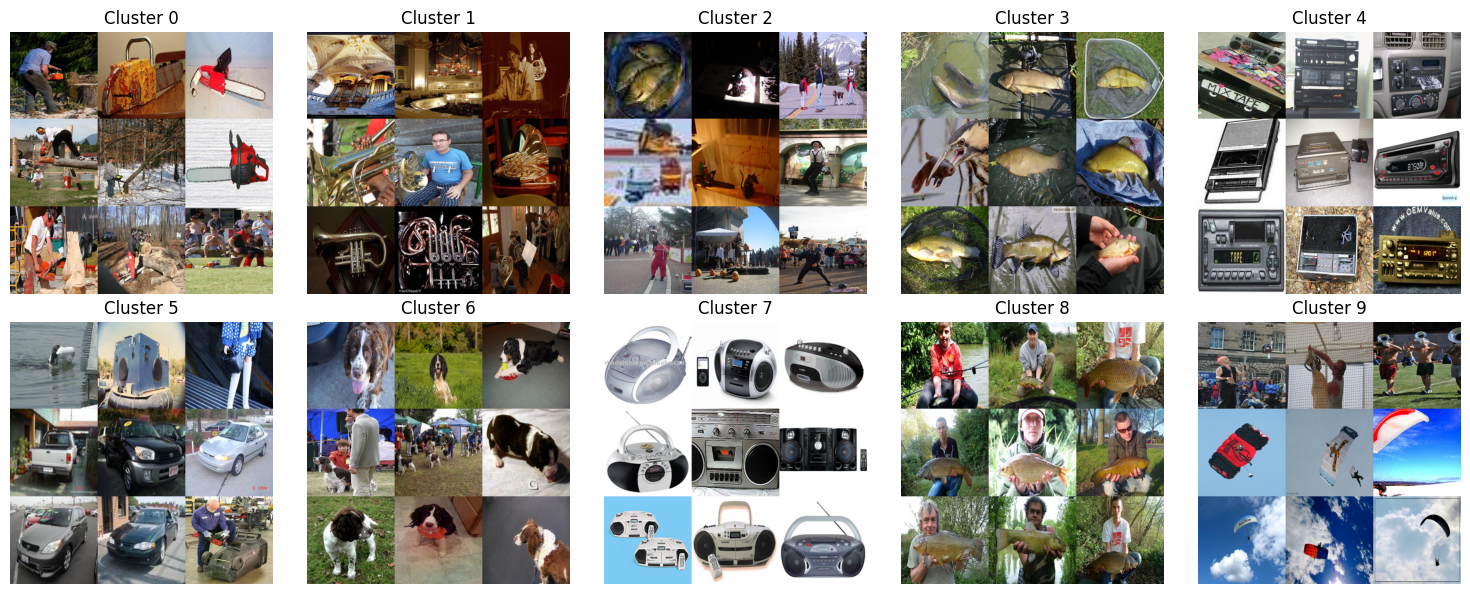

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid

import matplotlib.pyplot as plt
import numpy as np

import math
from PIL import Image
import numpy as np

import math
from PIL import Image


def create_image_grid(image_data, images_per_cluster, rows=None, cols=None, resize_to=(224, 224)):
    """
    Creates a grid of resized images based on the given image data.

    Parameters:
    - image_data (list): List of image file paths or PIL Image objects.
    - images_per_cluster (int): Number of images to display in the grid.
    - rows (int, optional): Number of rows in the grid. Default is ceil(sqrt(images_per_cluster)).
    - cols (int, optional): Number of columns in the grid. Default is ceil(sqrt(images_per_cluster)).
    - resize_to (tuple, optional): The size to which each image will be resized. Default is (224, 224).

    Returns:
    - PIL Image: The resulting grid image.
    """

    if rows is None or cols is None:
        grid_size = math.ceil(math.sqrt(images_per_cluster))
        rows = cols = grid_size

    # Resize all images to the desired size
    resized_images = [img.resize(resize_to) if isinstance(img, Image.Image) else Image.open(img).resize(resize_to) for img in image_data]

    # Calculate the grid size (row x col)
    grid_width = cols * resize_to[0]  # width of each image is resize_to[0]
    grid_height = rows * resize_to[1]  # height of each image is resize_to[1]

    # Create a new blank image with a white background
    grid_image = Image.new('RGB', (grid_width, grid_height), color='white')

    # Paste the resized images into the grid
    for i in range(images_per_cluster):
        row = i // cols
        col = i % cols
        img = resized_images[i]

        # Calculate the position to paste the image
        x_offset = col * resize_to[0]
        y_offset = row * resize_to[1]

        grid_image.paste(img, (x_offset, y_offset))

    return grid_image

    
def plot_cluster_images(dataset_samples, cluster_labels, cluster_names = None, clusters_per_row=3, images_per_cluster=4):
    """
    Visualizes images grouped by their cluster labels.
    
    Args:
        image_data: List or array of image data (could be numpy arrays or image file paths).
        cluster_labels: List or array of cluster labels corresponding to each image.
        clusters_per_row: The number of clusters to display in each row (integer).
        images_per_cluster: The number of images to display per cluster (integer).
    """
    image_data = [i[0] for i in dataset_samples]
    
    unique_clusters = np.unique(cluster_labels)
    
    # Initialize grid size based on clusters per row
    rows = int(np.ceil(len(unique_clusters) / clusters_per_row))
    
    # Create a new figure for the plot
    fig, axes = plt.subplots(rows, clusters_per_row, figsize=(clusters_per_row * 3, rows * 3))
    axes = axes.flatten()  # Flatten to easily iterate over axes

    # Plot images for each cluster
    for i, cluster in enumerate(unique_clusters):
        ax = axes[i]
        
        # Find images in the current cluster
        cluster_indices = np.where(cluster_labels == cluster)[0]
        
        # Select the first few images from this cluster
        merged_image = create_image_grid(np.array(image_data)[cluster_indices[:images_per_cluster]], images_per_cluster)
        # for j, idx in enumerate(cluster_indices[:images_per_cluster]):
        ax.imshow(merged_image)  # Show the image
        # ax.imshow(Image.open(image_data[idx]))  # Show the image
        ax.axis('off')  # Hide the axis

        if cluster_names is None:
            ax.set_title(f"Cluster {cluster}")  # Title with the cluster number
        else:
            ax.set_title(f"{cluster_names[i]}")  # Title with the cluster number
        
        # If there are no images left in this cluster, make sure the axis is turned off
        if len(cluster_indices) == 0:
            ax.axis('off')
    
    # Hide any unused axes
    for i in range(len(unique_clusters), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have `image_data` as a list of images (numpy arrays) and `cluster_labels` from your clustering method:

plot_cluster_images(dataset._samples, kmeans_labels, clusters_per_row=5, images_per_cluster=9)
